In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset
from counterfactuals.datasets.compas import CompasDataset

from counterfactuals.optimizers.approach_gen_disc import ApproachGenDisc

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

from counterfactuals.metrics.metrics import (
    perc_valid_cf,
    perc_valid_actionable_cf,
    continuous_distance,
    categorical_distance,
    distance_l2_jaccard,
    distance_mad_hamming,
    plausibility,
    delta_proba
)
from counterfactuals.utils import plot_loss_space

from torch.utils.data import DataLoader, TensorDataset

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dataset = MoonsDataset("../data/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)

In [8]:
# clf = LogisticRegression()
clf = MLPClassifier((128, 64), max_iter=100)
clf.fit(dataset.X_train, dataset.y_train)
y_pred_train = clf.predict(dataset.X_train)
y_pred_test = clf.predict(dataset.X_test)
print(classification_report(dataset.y_test, y_pred_test, output_dict=False))

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       797
         1.0       1.00      1.00      1.00       842

    accuracy                           1.00      1639
   macro avg       1.00      1.00      1.00      1639
weighted avg       1.00      1.00      1.00      1639



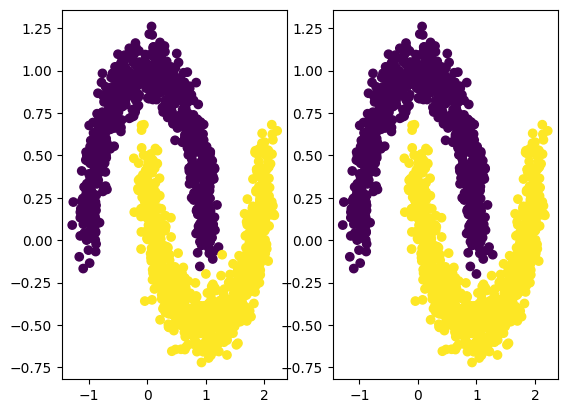

In [9]:
plt.subplot(1, 2, 1)
plt.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test)
plt.subplot(1, 2, 2)
plt.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=y_pred_test)

In [10]:
pred_train_dataloader = DataLoader(
    dataset=TensorDataset(
        torch.from_numpy(dataset.X_train),
        torch.from_numpy(clf.predict(dataset.X_train))
    ),
    shuffle=True,
    batch_size=128
)

pred_test_dataloader = DataLoader(
    dataset=TensorDataset(
        torch.from_numpy(dataset.X_test),
        torch.from_numpy(clf.predict(dataset.X_test))
    ),
    shuffle=False,
    batch_size=128
)

In [11]:
flow = MaskedAutoregressiveFlow(features=dataset.X_test.shape[1], hidden_features=16, num_blocks_per_layer=4, num_layers=8, context_features=None)
cf = ApproachGenDisc(model=flow, disc_model=clf)

In [12]:
cf.train_model(
    train_loader=pred_train_dataloader,
    test_loader=pred_test_dataloader,
    epochs=100,
)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 99, Train: 1.0570, test: 1.0334: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


(10000, 2)


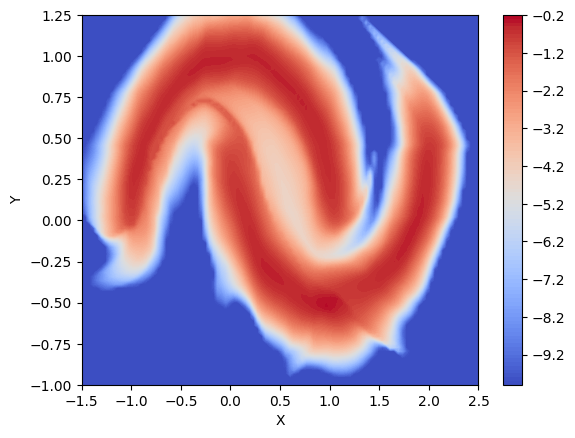

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1.5, 2.5, 100)
y = np.linspace(-1, 1.25, 100)
X, Y = np.meshgrid(x, y)
# Calculate the predictions for each point in the grid
print(np.c_[X.ravel(), Y.ravel()].shape)
Z = cf.predict_model(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)
Z[Z < -10] = -10

plt.contourf(X, Y, Z, levels=100, cmap='coolwarm')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

tensor([1.1147], grad_fn=<AddBackward0>) 0.19724443554878235 0.01812291331589222 0.02774990163743496


/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(-0.5867)


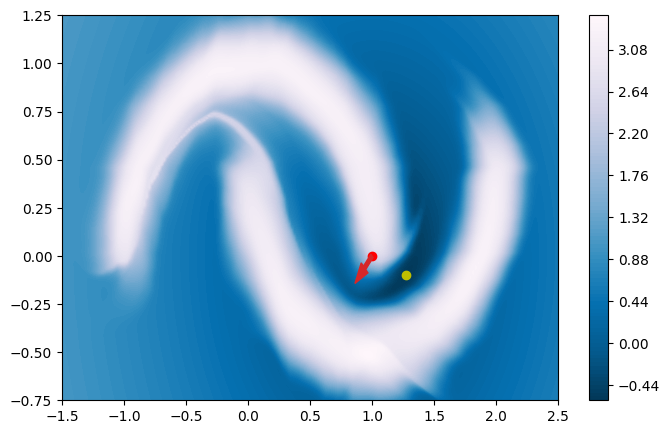

tensor([0.7715], grad_fn=<AddBackward0>) 0.2378336787223816 0.009629490785300732 0.017055947333574295
tensor(-0.5867)


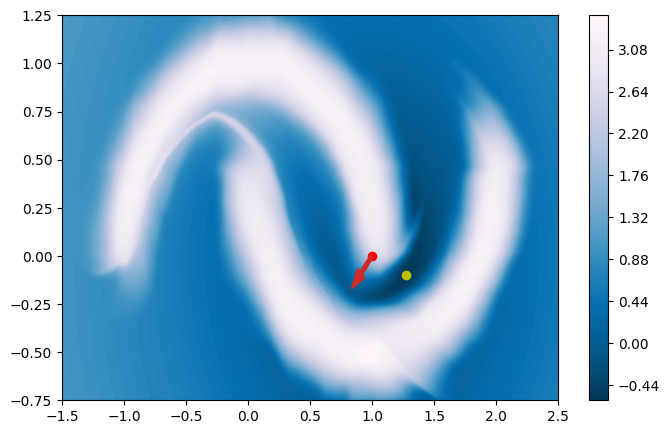

tensor([0.6554], grad_fn=<AddBackward0>) 0.24826161563396454 0.007188489660620689 0.013166362419724464
tensor(-0.5867)


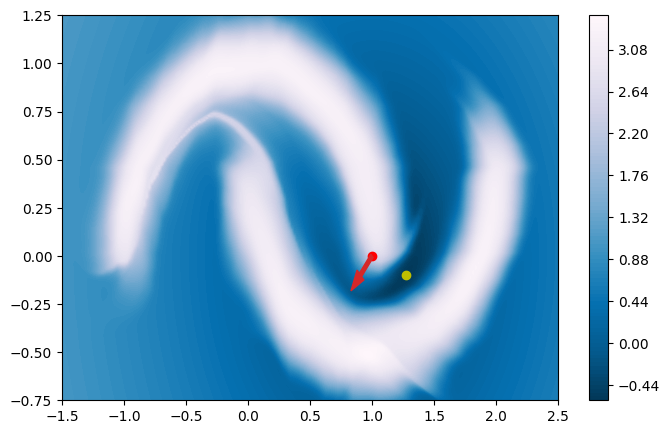

tensor([0.6311], grad_fn=<AddBackward0>) 0.2491353452205658 0.0066952891647815704 0.01240475382655859
tensor(-0.5867)


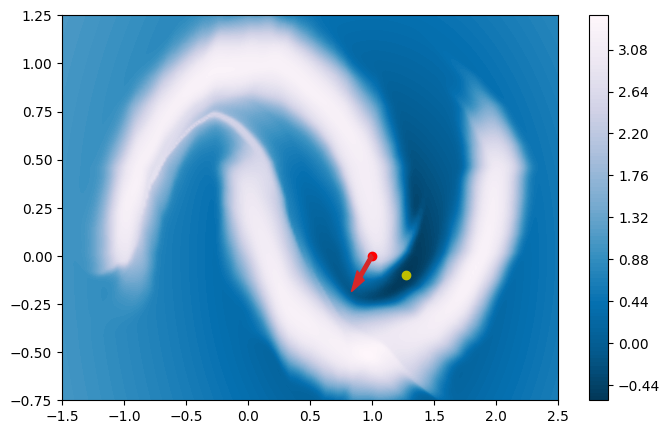

tensor([0.6322], grad_fn=<AddBackward0>) 0.24743075668811798 0.006718984339386225 0.012518377974629402
tensor(-0.5867)


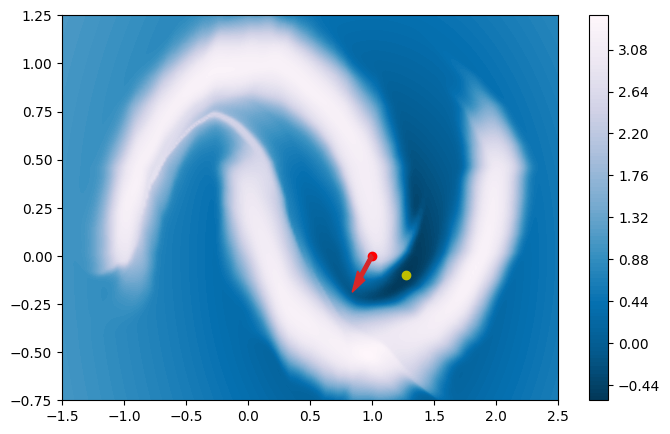

tensor([0.6335], grad_fn=<AddBackward0>) 0.24547724425792694 0.00674216216430068 0.012659154832363129
tensor(-0.5867)


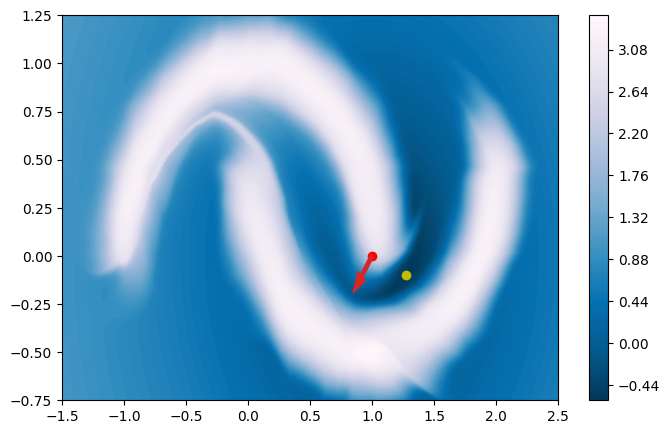

tensor([0.6336], grad_fn=<AddBackward0>) 0.24329642951488495 0.006738748867064714 0.012774070724844933
tensor(-0.5867)


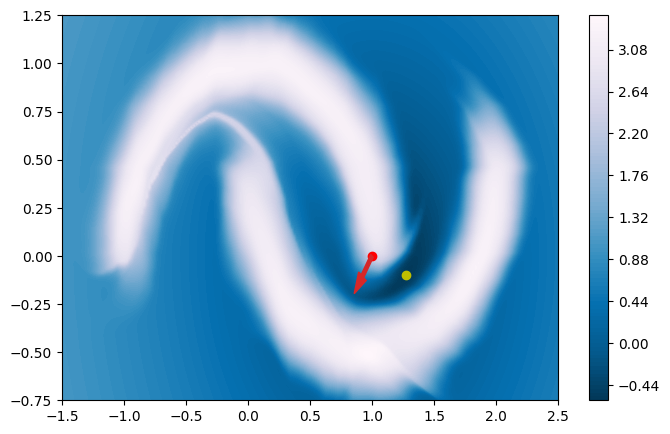

tensor([0.6374], grad_fn=<AddBackward0>) 0.24058367311954498 0.0067906505428254604 0.013051928952336311
tensor(-0.5867)


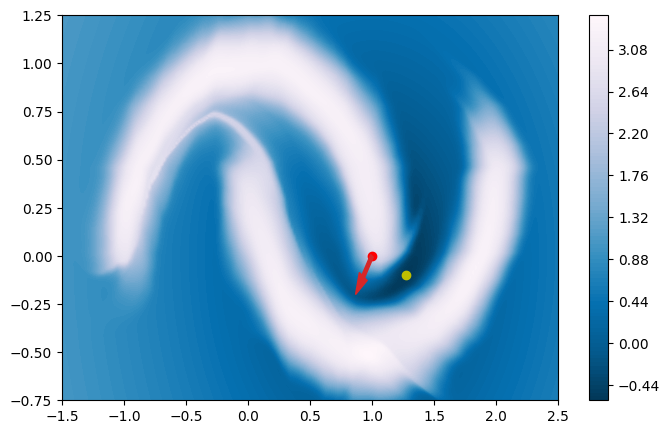

tensor([0.6464], grad_fn=<AddBackward0>) 0.23719201982021332 0.006905498448759317 0.013555282726883888
tensor(-0.5867)


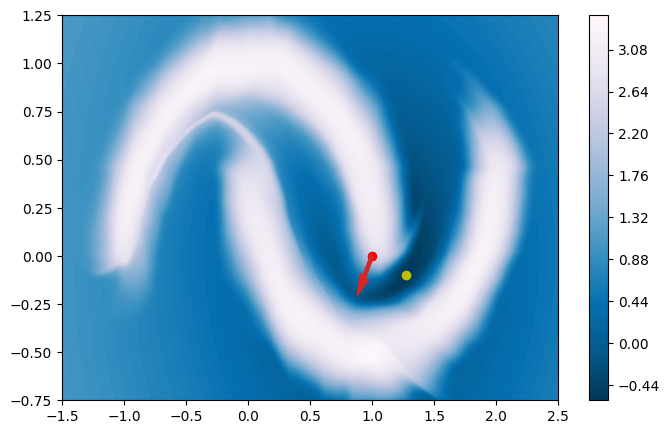

tensor([0.6504], grad_fn=<AddBackward0>) 0.23184293508529663 0.006891527213156223 0.014038454741239548
tensor(-0.5867)


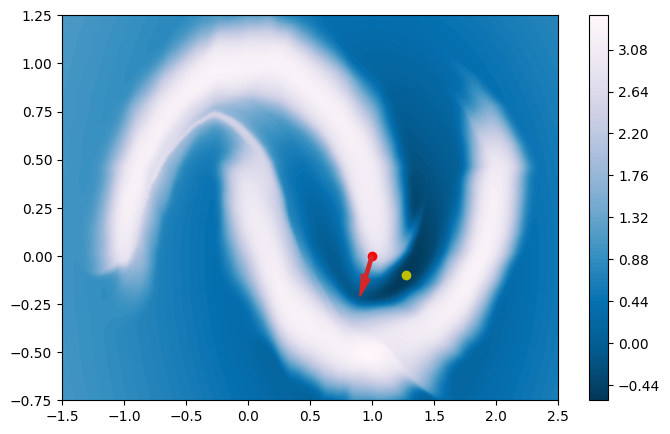

In [14]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)
optimizer = torch.optim.Adam([x], lr=0.005)
alpha = 20

num_iterations = 500
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1])

for i in range(num_iterations):
    y, dist, max_inner, max_outer = cf.search_step(x_param=x, x_origin=x_origin, context_origin=context_origin, context_target=context_target, alpha=alpha, beta=0.01)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 50 == 0:
        print(y, dist.detach().item(), max_inner.detach().item(), max_outer.detach().item())
        plot_loss_space(x, x_origin, cf.search_step, alpha=alpha, beta=0.01)

In [176]:
Xs_cfs, Xs, ys_orig = cf.search_batch(
    dataloader=pred_test_dataloader,
    epochs=300,
    lr=0.005,
    alpha=20,
    beta=0.01,
)
print(Xs_cfs)

100%|██████████| 13/13 [00:25<00:00,  1.94s/it]

[[ 1.703849    0.4061645 ]
 [ 0.38723698  1.3459817 ]
 [ 1.1207025  -0.18096413]
 ...
 [ 0.0129634   0.7487535 ]
 [ 0.7230949  -0.04341621]
 [ 1.5189596   0.12600988]]


In [177]:
# Xs_cfs = cf.generate_counterfactuals(Xs=dataset.X_test[:100], ys=dataset.y_test[:100], num_epochs=100, lr=0.005, alpha=20, beta=0.01)
# Xs_cfs = torch.concat(Xs_cfs).detach()

In [178]:
y_cfs_pred_mlpc = clf.predict(Xs_cfs)
y_orig_pred_mlpc = clf.predict(Xs)

In [179]:
ys_orig = ys_orig.flatten()

In [180]:
ys_cfs_pred = clf.predict(Xs_cfs)
ys_orig_pred = clf.predict(Xs)

{
    "valid_cf": perc_valid_cf(ys_orig_pred, y_cf=ys_cfs_pred),
    "valid_cf_for_orig_data": perc_valid_cf(ys_orig, y_cf=ys_cfs_pred),
    # "perc_valid_actionable_cf": perc_valid_actionable_cf(X=dataset.X_test[:100], X_cf=Xs_cfs, y=ys_orig_pred, y_cf=ys_cfs_pred, actionable_features=[1,2]),
    "continuous_distance": continuous_distance(X=Xs, X_cf=Xs_cfs, continuous_features=dataset.numerical_features, metric='mad', X_all=Xs),
    "categorical_distance": categorical_distance(X=Xs, X_cf=Xs_cfs, categorical_features=dataset.categorical_features, metric='jaccard', agg='mean'),
    "distance_l2_jaccard": distance_l2_jaccard(X=Xs, X_cf=Xs_cfs, continuous_features=dataset.numerical_features, categorical_features=dataset.categorical_features),
    "distance_mad_hamming": distance_mad_hamming(X=Xs, X_cf=Xs_cfs,
                                                 continuous_features=dataset.numerical_features, categorical_features=dataset.categorical_features, X_all=Xs, agg='mean'),
    "plausibility": plausibility(
        Xs, Xs_cfs, ys_orig,
        continuous_features_all=dataset.numerical_features,
        categorical_features_all=dataset.categorical_features,
        X_train=dataset.X_train,
        ratio_cont=None
    ),
    "delta_probability": delta_proba(Xs, Xs_cfs, classifier=clf),
    "log_density": np.mean(cf.predict_model(test_dataloader))
}

{'valid_cf': 0.1586333129957291,
 'valid_cf_for_orig_data': 0.1586333129957291,
 'continuous_distance': 0.7978086934844429,
 'categorical_distance': 0.0,
 'distance_l2_jaccard': 0.30264364110165837,
 'distance_mad_hamming': nan,
 'plausibility': nan,
 'delta_probability': 0.14799057,
 'log_density': -1.1662055}